In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pathlib
from sklearn.metrics import f1_score
from geoband.API import *
import folium
from folium import plugins
import json
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString, shape, mapping
from shapely.ops import unary_union
import jenkspy
import warnings
import pyproj
from fiona.crs import from_epsg

warnings.filterwarnings('ignore')

# 1. Data Loading

In [2]:
# 제공된 데이터
GetCompasData('SBJ_2012_001', '1', '1.오산시_주정차단속(2018~2020).csv')
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
GetCompasData('SBJ_2012_001', '3', '3.오산시_차량등록현황_격자.geojson')
GetCompasData('SBJ_2012_001', '5', '5.오산시_연령별_거주인구격자(유소년).geojson')
GetCompasData('SBJ_2012_001', '8', '8.오산시_유동인구(2019).csv')
GetCompasData('SBJ_2012_001', '9', '9.오산시_어린이보호구역.csv')
GetCompasData('SBJ_2012_001', '13', '13.오산시_어린이집_유치원현황.csv')
GetCompasData('SBJ_2012_001', '16', '16.오산시_도로안전표지표준데이터.csv')
GetCompasData('SBJ_2012_001', '17', '17.오산시_횡단보도.geojson')
GetCompasData('SBJ_2012_001', '18', '18.오산시_과속방지턱표준데이터.csv')
GetCompasData('SBJ_2012_001', '19', '19.오산시_신호등.geojson')
GetCompasData('SBJ_2012_001', '20', '20.오산시_CCTV설치현황.csv')
GetCompasData('SBJ_2012_001', '21', '21.오산시_인도.geojson')
GetCompasData('SBJ_2012_001', '22', '22.오산시_버스정류장.csv')
GetCompasData('SBJ_2012_001', '23', '23.오산시_상세도로망_LV6.geojson')
GetCompasData('SBJ_2012_001', '24', '24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
GetCompasData('SBJ_2012_001', '25', '25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
GetCompasData('SBJ_2012_001', '26', '26.평일_전일_오산시_혼잡시간강도_Level6.csv')
GetCompasData('SBJ_2012_001', '29', '29.오산시_체육시설현황.csv')
GetCompasData('SBJ_2012_001', '30', '30.오산시_학원_및_교습소_현황.csv')
GetCompasData('SBJ_2012_001', '31', '31.오산시_법정경계(시군구).geojson')

In [3]:
data1 = pd.read_csv('1.오산시_주정차단속(2018~2020).csv')
data2 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
data3 = gpd.read_file('3.오산시_차량등록현황_격자.geojson')
data5 = gpd.read_file('5.오산시_연령별_거주인구격자(유소년).geojson')
data8 = pd.read_csv('8.오산시_유동인구(2019).csv')
data9 = pd.read_csv('9.오산시_어린이보호구역.csv')
data13 = pd.read_csv('13.오산시_어린이집_유치원현황.csv')
data16 = pd.read_csv('16.오산시_도로안전표지표준데이터.csv')
data17 = gpd.read_file('17.오산시_횡단보도.geojson')
data18 = pd.read_csv('18.오산시_과속방지턱표준데이터.csv')
data19 = gpd.read_file('19.오산시_신호등.geojson')
data20 = pd.read_csv('20.오산시_CCTV설치현황.csv')
data21 = gpd.read_file('21.오산시_인도.geojson')
data22 = pd.read_csv('22.오산시_버스정류장.csv')
data23 = gpd.read_file('23.오산시_상세도로망_LV6.geojson')
data24 = pd.read_csv('24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
data25 = pd.read_csv('25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
data26 = pd.read_csv('26.평일_전일_오산시_혼잡시간강도_Level6.csv')
data29 = pd.read_csv('29.오산시_체육시설현황.csv')
data30 = pd.read_csv('30.오산시_학원_및_교습소_현황.csv')
data31 = gpd.read_file('31.오산시_법정경계(시군구).geojson')

In [4]:
# 외부 데이터
data36 = gpd.GeoDataFrame.from_file('MOCT_NODE.shp', encoding='cp949')
data37 = pd.read_excel("Extra.경기도_오산시_주차장.xlsx")
data38 = pd.read_excel("Extra.오산시시설관리공단_주차장정보.xlsx")

# 2. Data Preprocessing

In [5]:
def Count(grid, data) :
    col = []
    for i in range(len(grid)) :
        cnt = 0
        for j in range(len(data)) :
            if grid.gid[i] == data.gid[j] :
                cnt += 1
        col.append(cnt)
    return(col)

- overlay한 data격자 내 겹치는 data들을 count하는 함수

## 0) 오산시 어린이교통사고
- 격자 내 어린이 교통사고 발생 건수에 대한 정보
- 2. 오산시 어린이교통사고

In [6]:
data2

,gid,accident_cnt,geometry
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ..."
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ..."
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ..."
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ..."
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ..."
...,...,...,...
4505,다사646052,0,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ..."
4506,다사646053,0,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ..."
4507,다사647050,0,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ..."
4508,다사647051,0,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ..."


- accident_cnt : 격자 내 어린이 교통사고 수, 목적 변수

In [7]:
data2.isnull().sum()

gid             0
accident_cnt    0
geometry        0
dtype: int64

In [20]:
data2.accident_cnt.value_counts().sort_index()

0     4165
1      238
2       63
3       25
4        7
5        7
6        3
7        1
10       1
Name: accident_cnt, dtype: int64

- NA 없음

In [9]:
# 지도 추가
# 사고가 일어난 격자와 안전표지
map = folium.Map(
    location=[37.15908,127.04421],
    zoom_start=13
)

folium.GeoJson(
    data2,
).add_to(map)

map

- 2. 어린이 교통사고 data는 오산시를 가로, 세로 각 100m의 격자로 나눈 구역을 각 row로 하는 data

## 1) 안전시설물 정보
- 기존에 설치되어있던 안전시설물들에 대한 정보
- 9. 어린이 보호구역, 16. 도로안전표지, 18. 과속방지턱

### a) 어린이 보호구역

In [10]:
data9

,시설종류,시설명,CCTV설치여부,CCTV설치대수,보호구역도로폭,보호구역_경도,보호구역_위도
0,특수학교,성심학교,N,0,25,127.017521,37.176762
1,초등학교,가수초등학교,Y,1,12,127.047957,37.148103
2,초등학교,광성초등학교,Y,2,12,127.039709,37.184197
3,초등학교,대호초등학교,Y,3,12,127.057889,37.159106
4,초등학교,매홀초등학교,Y,2,6,127.063282,37.162749
...,...,...,...,...,...,...,...
86,어린이집,시립세마어린이집,Y,1,12,127.044916,37.184608
87,어린이집,미래숲어린이집,Y,1,6,127.044384,37.145326
88,어린이집,시립은여울어린이집,N,0,20,127.066860,37.170952
89,어린이집,설리반어린이집,N,0,5,127.061041,37.164127


- 어린이 보호구역 개수 : 91개

In [11]:
data9.isnull().sum()

시설종류        0
시설명         0
CCTV설치여부    0
CCTV설치대수    0
보호구역도로폭     0
보호구역_경도     0
보호구역_위도     0
dtype: int64

- NA 없음

In [12]:
data9['시설종류'].value_counts()

어린이집    48
초등학교    25
유치원     17
특수학교     1
Name: 시설종류, dtype: int64

- 특수학교, 초등학교, 유치원, 어린이집 포함

In [13]:
geom9 = gpd.points_from_xy(data9['보호구역_경도'], data9['보호구역_위도'])
gpd9 = gpd.GeoDataFrame(geometry = geom9, crs=from_epsg(4326))
crs9 = gpd9.to_crs(epsg='4326')
buf9 = gpd.GeoDataFrame()
buf9.geometry = crs9.buffer(0.0005)
poly9 = buf9.to_crs(epsg='4326')
over9 = gpd.overlay(data2, poly9, how='intersection')
over9

,gid,accident_cnt,geometry
0,다사571087,0,"POLYGON ((127.01707 37.17698, 127.01785 37.176..."
1,다사571088,0,"POLYGON ((127.01785 37.17714, 127.01785 37.176..."
2,다사572087,0,"POLYGON ((127.01786 37.17639, 127.01785 37.176..."
3,다사572088,0,"POLYGON ((127.01785 37.17699, 127.01785 37.177..."
4,다사578108,0,"POLYGON ((127.02518 37.19594, 127.02562 37.195..."
...,...,...,...
336,다사637049,0,"POLYGON ((127.09126 37.14211, 127.09126 37.142..."
337,다사636059,0,"POLYGON ((127.09039 37.15202, 127.09121 37.152..."
338,다사636060,0,"POLYGON ((127.09121 37.15237, 127.09121 37.152..."
339,다사637059,0,"POLYGON ((127.09121 37.15160, 127.09121 37.152..."


- 어린이 보호구역을 반경 50m 정도의 구역으로 설정하여 격자들과 overlay되는 보호구역을 나타내는 data 생성

In [14]:
num9 = Count(data2, over9)
schoolzone_num = pd.DataFrame({'schoolzone_num' : num9})
schoolzone_num.head()

,schoolzone_num
0,0
1,0
2,0
3,0
4,0


- 격자 내 어린이 보호구역 수를  count한 schoolzone_num 생성

### b) 도로안전표지

In [15]:
data16

,표지일련번호,표지종별,lon,lat
0,ER-400[봉담동탄고속도로]-상-60,2방향예고표지,127.069227,37.182663
1,NR-1[경기대로]-하-1982,시/군계표지,127.040826,37.197859
2,UR(오산시)-16[남부대로]-상-5,3방향도로명예고표지,127.070216,37.135929
3,UR(오산시)-16[남부대로]-하-3,3방향표지,127.064316,37.135531
4,UR(오산시)-16[남부대로]-하-4,3방향예고표지,127.051717,37.134248
...,...,...,...,...
826,UR(오산시)-[부원로]-하-2,2방향표지,127.084624,37.144540
827,RR-310[가장로]-상-170,2방향예고표지,127.035840,37.160577
828,RR-82[성호대로]-하-51,사설표지(허가),127.064309,37.149266
829,RR-82[성호대로]-하-52,하천표지,127.062244,37.149482


- 도로안전표지 : 831개

In [16]:
data16.isnull().sum()

표지일련번호    0
표지종별      0
lon       0
lat       0
dtype: int64

- NA 없음

In [17]:
data16['표지종별'].unique()

array(['2방향예고표지', '시/군계표지', '3방향도로명예고표지', '3방향표지', '3방향예고표지', '3방향도로명표지',
       '2방향표지', '200m 출구감속표지', '300m 출구감속표지', '小형_휴게소(예고)표지',
       '100m 출구감속표지', '미분류', '종합휴게소2차예고표지', '출구점예고표지(2지명)_150m예고',
       '단일노선표지', '분기점표지', '1방향예고표지', '1방향표지', '3방향1차예고표지', '종점표지', '하천표지',
       '출구점표지(2지명)', '나가는곳표지', '돌아가는길표지', '2지명방향표지', '매표소표지', '읍/면/동계표지',
       '1지명이정표지', '3방향2차예고표지', '2방향2차예고표지', '종합휴게소3차예고표지', '종합휴게소1차예고표지',
       '2방향1차예고표지', '관광지표지(사설 관광지표지 제외)', '2지명이정표지', '미분류방향표지', '3지명이정표지',
       '2차출구예고표지(2방향)_1Km예고', '2방향도로명표지', '2방향도로명예고표지', '사설표지(허가)',
       '자동차전용도로표지(430-1)', '유도표지', '정류장표지', '약식3방향표지', '1지명방향표지',
       '출구점표지(1지명)', '교량표지', '터널표지'], dtype=object)

- 방향표지 : 갈림길을 나타내는 표지
- 방향예고표지 : 일정거리 이후에 갈림길이 있음을 예고하는 표지, 방향도로명표지 : 갈림길을 도로명으로 나타낸 표지

In [18]:
data16 = data16[data16.표지종별.isin(['2방향표지','3방향표지','2방향도로명표지','3방향도로명표지'])]

- 방향표지만 사용

In [19]:
geom16 = gpd.points_from_xy(data16['lon'], data16['lat'])
res16 = []
for i in range(len(data2)):
    res16.append(geom16.within(data2.geometry[i]))
cnt16 = pd.DataFrame(res16).transpose().sum()

In [20]:
safetysign_num = pd.DataFrame({'safetysign_num' : cnt16})
safetysign_num.head()

,safetysign_num
0,0
1,0
2,0
3,0
4,0


- 각 격자 내의 도로안전표지 개수를 count한 safetysign_num 생성

### c) 과속방지턱

In [21]:
data18

,도로명,설치장소명,과속방지턱높이,과속방지턱폭,과속방지턱연장,보차분리여부,연속형여부,설치위치_경도,설치위치_위도
0,오산로,소망빌 앞,10,3.6,5.4,N,Y,127.068954,37.130852
1,동부대로,태영철강재공장 앞,10,3.6,5.0,N,Y,127.076305,37.137946
2,밀머리로,메디마트 앞,0,3.6,5.4,Y,Y,127.075093,37.141466
3,오산로,다인하우스 앞,10,3.6,10.0,Y,Y,127.071169,37.143833
4,운천로,운천고등학교 앞,10,3.6,6.0,Y,Y,127.080466,37.155872
5,성호대로,오산우체국 앞,10,3.6,5.0,Y,Y,127.070781,37.149169
6,경기대로,오산동 어린이공원 앞,10,3.6,6.0,N,Y,127.072608,37.151294
7,청학로,오산중학교 앞,10,3.6,6.5,Y,Y,127.061185,37.155124
8,청학로,세산다세대 부근,10,3.6,4.3,Y,N,127.062582,37.152656
9,청학로,정석빌딩 앞,10,3.6,4.4,Y,N,127.062101,37.150484


- 과속방지턱 : 29개

In [22]:
data18.isnull().sum()

도로명        0
설치장소명      0
과속방지턱높이    0
과속방지턱폭     0
과속방지턱연장    0
보차분리여부     0
연속형여부      0
설치위치_경도    0
설치위치_위도    0
dtype: int64

- NA 없음

In [23]:
geom18 = gpd.points_from_xy(data18['설치위치_경도'], data18['설치위치_위도'])
res18 = []
for i in range(len(data2)):
    res18.append(geom18.within(data2.geometry[i]))
cnt18 = pd.DataFrame(res18).transpose().sum()

In [24]:
bump_num = pd.DataFrame({'bump_num' : cnt18})
bump_num.head()

,bump_num
0,0
1,0
2,0
3,0
4,0


- 각 격자 내의 과속방지턱 개수를 count한 bump_num 생성

## 2) 어린이 관련 정보
- 어린이 정보와 어린이 관련된 시설 정보
- 5. 유소년 거주인구, 10. 초등학교 13. 어린이집, 유치원, 29. 체육시설, 30. 학원, 교습소

### a) 유소년 거주인구

In [29]:
data5

,gid,val,geometry
0,다사551085,NaN,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ..."
1,다사551086,NaN,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ..."
2,다사551087,NaN,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ..."
3,다사551088,NaN,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ..."
4,다사552085,NaN,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ..."
...,...,...,...
4505,다사646052,NaN,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ..."
4506,다사646053,NaN,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ..."
4507,다사647050,NaN,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ..."
4508,다사647051,NaN,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ..."


- NaN 값 존재 -> 산간, 도로 등 유소년 인구 측정 불가한 곳이라 생각

In [30]:
data5 = data5.fillna(0)
data5

,gid,val,geometry
0,다사551085,0.0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ..."
1,다사551086,0.0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ..."
2,다사551087,0.0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ..."
3,다사551088,0.0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ..."
4,다사552085,0.0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ..."
...,...,...,...
4505,다사646052,0.0,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ..."
4506,다사646053,0.0,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ..."
4507,다사647050,0.0,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ..."
4508,다사647051,0.0,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ..."


- NaN 값을 0으로 치환

In [31]:
child_num = pd.DataFrame({'child_num' : data5.val})
child_num.head()

,child_num
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


- 격자 내 유소년 인구 수인 child_num 생성

### b) 초등학교 + 어린이집, 유치원

#### i) 초등학교 from 9. 어린이 보호구역

In [32]:
data9

,시설종류,시설명,CCTV설치여부,CCTV설치대수,보호구역도로폭,보호구역_경도,보호구역_위도
0,특수학교,성심학교,N,0,25,127.017521,37.176762
1,초등학교,가수초등학교,Y,1,12,127.047957,37.148103
2,초등학교,광성초등학교,Y,2,12,127.039709,37.184197
3,초등학교,대호초등학교,Y,3,12,127.057889,37.159106
4,초등학교,매홀초등학교,Y,2,6,127.063282,37.162749
...,...,...,...,...,...,...,...
86,어린이집,시립세마어린이집,Y,1,12,127.044916,37.184608
87,어린이집,미래숲어린이집,Y,1,6,127.044384,37.145326
88,어린이집,시립은여울어린이집,N,0,20,127.066860,37.170952
89,어린이집,설리반어린이집,N,0,5,127.061041,37.164127


- 91개의 보호구역 존재 -> 초등학교 포함

In [33]:
data9_elem = data9[data9['시설종류'] == '초등학교']
data9_elem = data9_elem.reset_index(drop=True)
data9_elem

,시설종류,시설명,CCTV설치여부,CCTV설치대수,보호구역도로폭,보호구역_경도,보호구역_위도
0,초등학교,가수초등학교,Y,1,12,127.047957,37.148103
1,초등학교,광성초등학교,Y,2,12,127.039709,37.184197
2,초등학교,대호초등학교,Y,3,12,127.057889,37.159106
3,초등학교,매홀초등학교,Y,2,6,127.063282,37.162749
4,초등학교,삼미초등학교,Y,2,6,127.060269,37.191356
5,초등학교,성산초등학교,Y,3,12,127.067040,37.150444
6,초등학교,성호초등학교,Y,2,12,127.070953,37.150478
7,초등학교,수청초등학교,Y,3,18,127.055474,37.170857
8,초등학교,오산초등학교,Y,3,6,127.050165,37.145158
9,초등학교,오산고현초등학교,Y,2,12,127.085145,37.133417


- 초등학교 : 25개
- 10. 초등학교 data보다 9.어린이 보호구역 data의 초등학교 정보가 더 최신 정보였음

In [34]:
geom9_elem = gpd.points_from_xy(data9_elem['보호구역_경도'], data9_elem['보호구역_위도'])
res9_elem = []
for i in range(len(data2)):
    res9_elem.append(geom9_elem.within(data2.geometry[i]))
cnt9_elem = pd.DataFrame(res9_elem).transpose().sum()

In [35]:
elem_num = pd.DataFrame({'elem_num' : cnt9_elem})
elem_num.head()

,elem_num
0,0
1,0
2,0
3,0
4,0


- 격자 내 초등학교 수를 count한 elem_num 생성

#### ii) 어린이집, 유치원

In [36]:
data13

,시설구분,시설타입,시설명,시설위치_경도,시설위치_위도
0,어린이집,민간,해오름어린이집,127.084336,37.132383
1,어린이집,가정,햇살가득어린이집,127.041817,37.182164
2,어린이집,가정,행복한아이들어린이집,127.079494,37.152891
3,어린이집,가정,휴튼사과나무어린이집,127.049638,37.177976
4,어린이집,직장,(주)아모레퍼시픽 오산어린이집,127.040252,37.165311
...,...,...,...,...,...
302,유치원,공립,매홀초등학교병설유치원,127.063587,37.162365
303,유치원,공립,문시초등학교병설유치원,127.045862,37.174141
304,유치원,공립,세교유치원,127.044332,37.177051
305,유치원,공립,수청초등학교병설유치원,127.055667,37.170668


In [37]:
data13.시설구분.value_counts()

어린이집    257
유치원      50
Name: 시설구분, dtype: int64

- 어린이집, 유치원 : 307개

In [38]:
data13.isnull().sum()

시설구분       0
시설타입       0
시설명        0
시설위치_경도    0
시설위치_위도    0
dtype: int64

- NA 없음

In [39]:
geom13 = gpd.points_from_xy(data13['시설위치_경도'], data13['시설위치_위도'])
res13 = []
for i in range(len(data2)):
    res13.append(geom13.within(data2.geometry[i]))
cnt13 = pd.DataFrame(res13).transpose().sum()

In [40]:
kinder_num = pd.DataFrame({'kinder_num' : cnt13})
kinder_num.head()

,kinder_num
0,0
1,0
2,0
3,0
4,0


- 격자 내 어린이집, 유치원 수를 count한 kinder_num 생성

In [41]:
school_cnt = elem_num.elem_num + kinder_num.kinder_num
school_num = pd.DataFrame({'school_num' : school_cnt})
school_num

,school_num
0,0
1,0
2,0
3,0
4,0
...,...
4505,0
4506,0
4507,0
4508,0


- 어린이집, 유치원, 초등학교를 합한 school_num 생성

### c) 체육시설

In [42]:
data29

,시설구분명,설치위치_경도,설치위치_위도
0,육상시설,127.073804,37.157197
1,기타시설,127.041923,37.179440
2,기타시설,127.075720,37.158754
3,테니스,127.077445,37.149806
4,테니스,127.070223,37.155640
...,...,...,...
140,체육도장업,127.045700,37.147668
141,체육도장업,127.056167,37.160918
142,체육도장업,127.068877,37.150437
143,체육도장업,127.090695,37.150806


In [43]:
data29.시설구분명.value_counts()

체육도장업    131
테니스        6
수영장        3
구기체육관      2
기타시설       2
육상시설       1
Name: 시설구분명, dtype: int64

- 체육시설 : 145개

In [44]:
geom29 = gpd.points_from_xy(data29['설치위치_경도'], data29['설치위치_위도'])
res29 = []
for i in range(len(data2)):
    res29.append(geom29.within(data2.geometry[i]))
cnt29 = pd.DataFrame(res29).transpose().sum()

- 격자 내의 체육시설을 count

### d) 학원, 교습소

In [46]:
data30

,업종구분명,교습과정명,시설위치_경도,시설위치_위도
0,교습소,음악,127.048919,37.146279
1,교습소,미술,127.048919,37.146279
2,교습소,보습,127.052419,37.145809
3,학교교과교습학원,"종합(국,수,사,과,논술)",127.048919,37.146279
4,학교교과교습학원,피아노(체르니40이상),127.048919,37.146279
...,...,...,...,...
1781,학교교과교습학원,피아노중급반,127.050280,37.145999
1782,학교교과교습학원,국수사과,127.049558,37.142116
1783,학교교과교습학원,피아노(고급주3회),127.062722,37.165033
1784,학교교과교습학원,피아노초급,127.062722,37.165033


In [47]:
data30.업종구분명.value_counts()

학교교과교습학원    1590
평생직업교육학원     106
교습소           90
Name: 업종구분명, dtype: int64

- 학원, 교습소 : 1786개
- 평생직업교육학원 : 106개

In [48]:
data30_child = data30[data30.업종구분명!='평생직업교육학원']
data30_child

,업종구분명,교습과정명,시설위치_경도,시설위치_위도
0,교습소,음악,127.048919,37.146279
1,교습소,미술,127.048919,37.146279
2,교습소,보습,127.052419,37.145809
3,학교교과교습학원,"종합(국,수,사,과,논술)",127.048919,37.146279
4,학교교과교습학원,피아노(체르니40이상),127.048919,37.146279
...,...,...,...,...
1781,학교교과교습학원,피아노중급반,127.050280,37.145999
1782,학교교과교습학원,국수사과,127.049558,37.142116
1783,학교교과교습학원,피아노(고급주3회),127.062722,37.165033
1784,학교교과교습학원,피아노초급,127.062722,37.165033


- 평생직업교육학원 106개 제외 1680개 학원, 교습소

In [49]:
geom30 = gpd.points_from_xy(data30_child['시설위치_경도'], data30_child['시설위치_위도'])
res30 = []
for i in range(len(data2)):
    res30.append(geom30.within(data2.geometry[i]))
cnt30 = pd.DataFrame(res30).transpose().sum()

- 격자 내 학원, 교습소 수를  count

### c+d) 유소년 관련 시설

In [51]:
facility_cnt = cnt29 + cnt30
facility_cnt

0       0
1       0
2       0
3       0
4       0
       ..
4505    0
4506    0
4507    0
4508    0
4509    0
Length: 4510, dtype: int64

In [52]:
facility_num = pd.DataFrame({'facility_num' : facility_cnt})
facility_num

,facility_num
0,0
1,0
2,0
3,0
4,0
...,...
4505,0
4506,0
4507,0
4508,0


- 학원, 교습소 수와 체육시설 수를 합한 facility_num 생성

## 3) 도로 주변 정보
- 도로의 특성이나 주변 시설에 관한 정보
- 1. 주정차단속, 3.차량등록현황, 8. 유동인구, 17. 횡단보도, 19. 신호등, 21. 인도, 22. 버스정류장, Extra1. 교통노드,  Extra2. 주차장

### a) 주정차단속

In [53]:
data1

,단속일자,단속위치,행정구역,스쿨존여부,단속위치_경도,단속위치_위도,단속종류
0,20181101,금암동 여계산로 부근,경기도 오산시 세교동,N,127.043462,37.170237,이동형CCTV단속
1,20181101,세교동 세마역로19번길,경기도 오산시 세교동,N,127.044770,37.181695,이동형CCTV단속
2,20181101,세교동 수목원로 부근,경기도 오산시 양산동,N,127.042200,37.186357,이동형CCTV단속
3,20181101,오산동 오산로272번길 부,경기도 오산시 원동,N,127.071732,37.150557,이동형CCTV단속
4,20181101,오산동 성호대로93번길,경기도 오산시 부산동,N,127.071757,37.150457,이동형CCTV단속
...,...,...,...,...,...,...,...
61696,20201111,GS25궐동대호점 맞은편,경기도 오산시 청학동,N,127.053064,37.158140,고정형CCTV단속
61697,20201111,물향기지하도,경기도 오산시 원동,N,127.066157,37.171143,고정형CCTV단속
61698,20201111,운암2단지 근린공원삼거,경기도 오산시 청호동,N,127.077283,37.158126,고정형CCTV단속
61699,20201111,궐동 양평해장국 사거리,경기도 오산시 궐동,N,127.056665,37.155827,고정형CCTV단속


In [54]:
data1.isnull().sum()

단속일자         0
단속위치         0
행정구역         0
스쿨존여부        0
단속위치_경도    188
단속위치_위도    188
단속종류         0
dtype: int64

- 경도, 위도 data NA 188개

In [55]:
geom1_all = gpd.points_from_xy(data1['단속위치_경도'], data1['단속위치_위도'])
res1_all = gpd.GeoDataFrame({'geometry' : geom1_all})
osan = []
for i in range(len(geom1_all)) :
    osan.append(res1_all.geometry[i].within(data31.geometry[0]))
geom1 = geom1_all[osan]
data1_osan = data1[osan].reset_index(drop=True)

- 오산시 내에서 적발된 주정차단속 건수만 선정

In [56]:
data1_osan.행정구역.unique()

array(['경기도 오산시 세교동', '경기도 오산시 양산동', '경기도 오산시 원동', '경기도 오산시 부산동',
       '경기도 오산시 오산동', '경기도 오산시 지곶동', '경기도 오산시 궐동', '경기도 오산시 서동',
       '경기도 오산시 금암동', '경기도 오산시 누읍동', '경기도 오산시 가수동', '경기도 오산시 청학동',
       '경기도 오산시 수청동', '경기도 오산시 고현동', '경기도 오산시 청호동', '경기도 오산시 은계동',
       '경기도 오산시 내삼미동', '경기도 오산시 갈곶동', '경기도 오산시 가장동', '경기도 오산시 서랑동',
       '경기도 오산시 외삼미동', '경기도 화성시 오산동', '경기도 오산시 벌음동', '경기도 오산시 탑동',
       '경기도 오산시 두곡동', '충청북도 청주시 흥덕구 옥산면 오산리', '경기도 안성시 금광면 오산리',
       '전라북도 무주군 무주읍 오산리', '경기도 파주시 조리읍 오산리', '충청북도 음성군 대소면 오산리',
       '전라남도 곡성군 오산면', '경상북도 청도군 각북면 오산리', '전라북도 익산시 오산면',
       '경기도 용인시 처인구 모현읍 오산리', '전라북도 익산시 오산면 영만리', '경기도 양주시 백석읍 오산리'],
      dtype=object)

- geometry 정보는 오산시 내이지만 타 지역의 오산면, 오산리 단속 정보가 포함되어있는 error가 있었음

In [57]:
error = []
for i in range(len(data1_osan)):
    if "오산면" in data1_osan["행정구역"][i].split() or "오산리" in data1_osan["행정구역"][i].split():
        error.append(False)
    else: error.append(True)
geom1 = geom1[error]
data1_osan = data1_osan[error].reset_index(drop=True)

- 오산면, 오산리 등의 error 정보를 제외

In [58]:
res1 = []
for i in range(len(data2)):
    res1.append(geom1.within(data2.geometry[i]))
cnt1 = pd.DataFrame(res1).transpose().sum()
ill_park = pd.DataFrame({'ill_park' : cnt1})
ill_park.head()

KeyboardInterrupt: 

- 격자 내의 주정차단속 건수를 count한 ill_park 생성
- 주정차 단속 건수가 많아 코드 실행이 오래 걸림

### b) 차량등록현황

In [ ]:
data3

- 격자별 data

In [ ]:
data3.isnull().sum()

- NA 없음

In [ ]:
car_num = pd.DataFrame({'car_num' : data3.car_cnt})
car_num.head()

### c) 유동인구

In [ ]:
data8

In [ ]:
data8.isnull().sum()

- NA 없음

##### 어린이 교통사고 발생 빈도에 따라 가중치 준 유동인구

##### 시간대 가중치
- 새벽 1시, 2시, 3시, 4시: 0
- 오후 2시, 3시, 4시, 5시, 6시: 1.5
- 나머지 시간대: 1

In [ ]:
# 동일 위치(같은 위도, 경도)에 대한 유동인구의 평균
data8_mean = data8.iloc[:,1:28].groupby(by=["lon","lat"]).mean()
data8_mean = data8_mean.reset_index()
data8_mean

In [ ]:
# 시간대에 대해 어린이 교통사고 발생 빈도에 따라 가중치 부여
w = [1,0,0,0,0,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1,1,1,1,1]
w_mean = []
for i in range(len(data8_mean)):
    w_mean.append(sum(w * data8_mean.iloc[i,range(2,26)]))

In [ ]:
geom8 = gpd.points_from_xy(data8_mean['lon'], data8_mean['lat'])
data8_geom = pd.DataFrame({'geometry' : geom8, 'foot_traf' : w_mean})
data8_geom

In [ ]:
res8 = []
for i in range(len(data2)) :
    res8.append(geom8.within(data2.geometry[i]))
res8_df = pd.DataFrame(res8)

In [ ]:
mean8 = []
for i in range(len(data2)) :
    mean8.append(data8_geom.loc[list(res8_df.iloc[i,:]), 'foot_traf'].mean())

In [ ]:
foot_traf_mean = pd.DataFrame({'foot_traf_mean' : mean8}).fillna(0)
foot_traf_mean.head()

- 격자 내 유동인구의 평균을 계산한 foot_traf_mean 생성

### d) 횡단보도

In [ ]:
data17

In [ ]:
data17.isnull().sum()

In [ ]:
crs17 = data17.to_crs(epsg='4326')
buf17 = gpd.GeoDataFrame()
buf17.geometry = crs17.buffer(0.00013)
poly17 = buf17.to_crs(epsg='4326')
over17 = gpd.overlay(data2, poly17, how='intersection')
over17

- 격자들과 overlay되는 횡단보도를 나타내는 data 생성

In [ ]:
cnt17 = Count(data2, over17)
crosswalk_num = pd.DataFrame({'crosswalk_num' : cnt17})
crosswalk_num.head()

- 격자 내 횡단보도 수를 count한 crosswalk_num 생성

### e) 신호등

In [ ]:
data19

In [ ]:
data19.isnull().sum()

In [ ]:
res19 = []
for i in range(len(data2)):
    res19.append(data19.within(data2.geometry[i]))
cnt19 = pd.DataFrame(res19).transpose().sum()

In [ ]:
signal_num = pd.DataFrame({'signal_num' : cnt19})
signal_num.head()

- 격자 내 신호등 수를 count한 signal_num 생성

### f) 인도

In [ ]:
data21

In [ ]:
crs21 = data21.to_crs(epsg='4326')
buf21 = gpd.GeoDataFrame()
buf21.geometry = crs21.buffer(0.00013)
poly21 = buf21.to_crs(epsg='4326')
over21 = gpd.overlay(data2, poly21, how='intersection')
over21

- 격자들과 overlay되는 인도를 나타내는 data 생성

In [ ]:
cnt21 = Count(data2, over21)
sidewalk_num = pd.DataFrame({'sidewalk_num' : cnt21})
sidewalk_num.head()

- 격자 내 인도 수를 count한 sidewalk_num 생성

### g) 버스정류장

In [ ]:
data22

In [ ]:
data22.isnull().sum()

In [ ]:
geom_data22 = gpd.points_from_xy(data22['정류장 위치_경도'], data22['정류장 위치_위도'])
res22 = []
for i in range(len(data2)):
    res22.append(geom_data22.within(data2.geometry[i]))
cnt22 = pd.DataFrame(res22).transpose().sum()

In [ ]:
busstop_num = pd.DataFrame({'busstop_num' : cnt22})
busstop_num.head()

- 격자 내 버스정류장 수를 count한 busstop_num 생성

### h) 교통 노드

In [ ]:
data36 = data36.to_crs('epsg:4326')
data36

- data의 좌표 정보를 경도, 위도 단위로 변환

In [ ]:
osan = []
for i in range(len(data36)):
    osan.append(data36.geometry[i].within(data31.geometry[0]))
osan_node = data36[osan].reset_index()

- 오산시 내에 있는 교통 노드만 사용

In [ ]:
res36 = []
for i in range(len(data2)):
    res36.append(osan_node.within(data2.geometry[i]))
cnt36 = pd.DataFrame(res36).transpose().sum()

In [ ]:
node = pd.DataFrame({'node' : cnt36})
node.head()

- 격자 내 교통 노드 수를 count한 node 생성

### i) 주차장

In [ ]:
data39 = pd.concat([data37, data38], axis=0).reset_index(drop=True)
data39

- 오산시 주차장 정보가 담긴 두개의 dataset을 concatenate

In [ ]:
geom39 = gpd.points_from_xy(data39['경도'], data39['위도'])
gpd39 = gpd.GeoDataFrame(geometry = geom39, crs=from_epsg(4326))
crs39 = gpd39.to_crs(epsg='4326')
buf39 = gpd.GeoDataFrame()
buf39.geometry = crs39.buffer(0.0004)
poly39 = buf39.to_crs(epsg='4326')
over39 = gpd.overlay(data2, poly39, how='intersection')
over39

- 격자들과 overlay되는 주차장을 나타내는 data 생성

In [ ]:
grid39 = list(over39.gid.unique())
len(grid39)

- 주차장이 있는 격자는 총 137개

In [ ]:
grid39 = [x for x in grid39 if x not in ["다사606088","다사605088","다사610079","다사609079"]]
grid39 += ["다사607088","다사608088","다사610078","다사609078","다사608078","다사608077","다사610077"]
len(grid39)

- 실제 지도 정보를 보고 주차장 포함 격자 일부 수정

In [ ]:
exist39 =[]
for i in range(len(data2)):
    if data2.gid[i] in grid39 : exist39.append(1)
    else : exist39.append(0)

In [ ]:
park_YN = pd.DataFrame({'park_YN' : exist39})
park_YN.head()

- 격자 내 주차장 존재여부를 나타내는 park_YN 생성

## 4) 도로 교통 정보
- 도로 정보와 교통량, 정체 정도 등 직접적인 교통 정보들
- 23. 상세도로망, 24. 추정교통량, 25. 혼잡빈도강도, 26. 혼잡시간강도 

### a) 상세도로망

In [ ]:
data23.rename(columns={'link_id' : 'link_ID'}, inplace=True)
data23

In [ ]:
data23.isnull().sum()

- 도로명과 시설명에 NA가 각각 294, 1842개 존재

In [ ]:
search = '고속도로'
road = list(data23.road_name.dropna())
highway = []
for word in road:
    if search in word:
        highway.append(word)
highway = list(set(highway))
highway

- 오산의 차도 중 고속도로가 4가지 존재

In [ ]:
highway_index = data23.road_name.isin(highway)
data23 = data23[~highway_index].reset_index(drop=True)
data23

- 어린이 교통사고의 주 분석 범위에서 고속도로를 제외

### b) 추정교통량

In [ ]:
data24

In [ ]:
data24.isnull().sum()

- 도로명에 NA 12900개 존재

In [ ]:
data24 = data24.drop(columns=['시도명', '시군구명', '평일주말'])
for i in ['상세도로망_LinkID', '도로등급', '시간적범위'] :
    data24[i] = data24[i].apply(str)

- 필요없는 column (시도명, 시군구명, 평일주말) 삭제
- 상세도로망_LinkID, 도로등급, 시간적범위 categorical variable 처리

In [ ]:
link_ID = []
for i in range(len(data24)) :
    link_ID.append(data24.상세도로망_LinkID[i][:-2])
link_ID = pd.DataFrame({'link_ID' : link_ID})
data24 = pd.concat([link_ID, data24], axis=1)
data24

- 상세도로망 LinkID에서 상/하행 정보를 나타내는 끝 2자리를 제거한 link_ID 생성

In [ ]:
highway_index = data24.도로명.isin(highway)
data24 = data24[~highway_index].reset_index(drop=True)
data24

- 상세도로망과 마찬가지로 고속도로 정보 제외

In [ ]:
data24.시간적범위.value_counts()

- 시간에 따른 추정교통량을 측정했음을 확인

In [ ]:
time = list(map(str, list(range(5,25))))
data24 = data24[data24.시간적범위.isin(time)].reset_index(drop=True)
data24

- 어린이가 주로 활동하지 않는 시간대인 오전 1시에서 4시까지의 data 제외

In [ ]:
columns = ['link_ID', '상세도로망_LinkID', '도로등급', '링크길이', '읍면동명']
data24_sum = data24.groupby(columns, as_index=False).sum()
data24_sum = pd.merge(data24_sum, data24.iloc[:,[0,4]], on='link_ID', how='left')
data24_sum = data24_sum.drop_duplicates(['link_ID', '상세도로망_LinkID'], keep='first')
data24 = data24_sum[['link_ID', '상세도로망_LinkID', '도로명', '도로등급', '링크길이', '읍면동명', '전체 추정교통량', '승용차 추정교통량', '버스 추정교통량', '화물차 추정교통량']]
data24

- 시간대별 추정교통량을 합해서 각 도로별 일 추정 교통량 data 생성

In [ ]:
sum(data24['전체 추정교통량']==0)

In [ ]:
data24 = data24[data24['전체 추정교통량']!=0].reset_index(drop=True)
data24

- 추정교통량이 0인 도로 3개는 사고 가능성이 없다고 판단해 제외

In [ ]:
bigcar_ratio = (data24['버스 추정교통량'] + data24['화물차 추정교통량']) / data24['전체 추정교통량']
bigcar_ratio = pd.DataFrame({'bigcar_ratio' : bigcar_ratio})
data24 = pd.concat((data24, bigcar_ratio), axis=1)
data24

- (버스 추정교통량 + 화물차 추정교통량) / 전체 추정교통량을 나타내는 bigcar_ratio 생성

In [ ]:
data24 = data24.drop(columns=['승용차 추정교통량', '버스 추정교통량', '화물차 추정교통량'])
data24

- 각 차종별 추정교통량은 제외

### c) 혼잡빈도강도, 혼잡시간강도

#### i) 혼잡빈도강도

In [ ]:
data25

- 상세도로망_LinkID, 도로등급 categorical variable 처리

In [ ]:
data25.isnull().sum()

- 도로명 NA 382개 존재

#### ii) 혼잡시간강도

In [ ]:
data26

- 상세도로망_LinkID, 도로등급 categorical variable 처리

In [ ]:
data26.isnull().sum()

- 도로명 NA 382개 존재 (혼잡빈도강도와 동일)

In [ ]:
data25_part = data25.loc[:,['상세도로망_LinkID', '혼잡빈도강도']]
jam = pd.merge(data25_part, data26, on='상세도로망_LinkID', how='outer')
jam = jam[['상세도로망_LinkID', '도로등급', '링크길이', '도로명', '혼잡시간강도', '혼잡빈도강도']]
jam

- 혼잡빈도강도와 혼잡시간강도 정보를 merge

In [ ]:
jam[['혼잡시간강도', '혼잡빈도강도']].corr()

- 혼잡시간강도와 혼잡빈도강도의 상관계수 = 0.92073

In [ ]:
jam = jam.drop(columns=['혼잡시간강도'])
jam

- 두 변수가 유사한 변수라고 판단해 혼잡시간강도를 제외하고 혼잡빈도강도만 변수로 사용

In [ ]:
for column in ['상세도로망_LinkID', '도로등급']:
    jam[column] = jam[column].apply(str)

In [ ]:
link_ID = []
for i in range(len(jam)) :
    link_ID.append(jam.상세도로망_LinkID[i][:-2])
link_ID = pd.DataFrame({'link_ID' : link_ID})
jam = pd.concat([link_ID, jam], axis=1)
jam

- 상세도로망 LinkID에서 상/하행 정보를 나타내는 끝 2자리를 제거한 link_ID 생성

In [ ]:
highway_index = jam.도로명.isin(highway)
jam = jam[~highway_index].reset_index(drop=True)
jam

- 상세도로망, 추정교통량과 마찬가지로 고속도로 제외

### b+c) 교통량 + 혼잡강도

In [ ]:
print('교통량 - 혼잡강도:', len(set(data24.link_ID) - set(jam.link_ID)))
print('혼잡강도 - 교통량:', len(set(jam.link_ID) - set(data24.link_ID)))

In [ ]:
traffic_info = pd.merge(jam, data24, on=['link_ID', '상세도로망_LinkID', '도로등급', '링크길이', '도로명'], how='left')
traffic_info['전체 추정교통량'].fillna(value=traffic_info.median()['전체 추정교통량'], inplace=True)
traffic_info['bigcar_ratio'].fillna(value=traffic_info.median()['bigcar_ratio'], inplace=True)
traffic_info = traffic_info[['link_ID', '상세도로망_LinkID', '도로명', '도로등급', '링크길이', '읍면동명', '전체 추정교통량', 'bigcar_ratio', '혼잡빈도강도']]
traffic_info

- 추정교통량 data와 혼잡강도 data를 merge
- merge했을 때의 NA를 적게 하기 위해 혼잡강도 data에 교통량 data를 merge
- 전체 추정교통량과 bigcar_ratio NA를 median으로 imputation
- 그 후 column 순서 조정

In [ ]:
road_name = traffic_info.loc[:, ['link_ID', '도로명']].drop_duplicates('link_ID', keep='first')
traffic_info = traffic_info.groupby(['link_ID', '읍면동명', '도로등급'], as_index=False).mean()
traffic_info = pd.merge(traffic_info, road_name, on='link_ID')
traffic_info

- 상하행선을 모두 포함한 도로는 추정교통량, bigcar_ratio, 혼잡시간강도, 혼잡빈도강도를 평균내서 같은 link_ID로 묶음
- 3004 rows -> 1694 rows

### a+b+c) 상세도로망 + 교통량 + 혼잡강도

In [ ]:
roadnet = data23
roadnet.width = roadnet.width.apply(float)
roadnet['road_width'] = roadnet['width'] / roadnet['width'].max()

- 각 도로폭을 최대도로폭으로 나눈 정규화도로폭 road_width 생성

In [ ]:
roadnet = traffic_info.merge(roadnet, on='link_ID')
columns = ['link_ID', '도로명', '전체 추정교통량', 'bigcar_ratio', '혼잡빈도강도', 'road_width', 'geometry']
roadnet = roadnet[columns]
roadnet

- 상세도로망과 도로정보를 ID에 대해 merge

In [ ]:
roadnet = gpd.GeoDataFrame(roadnet, crs = 'EPSG:4326', geometry = roadnet.geometry)
roadnet['geometry'] = roadnet.geometry.buffer(0.00001)

In [ ]:
over23 = gpd.overlay(data2, roadnet, how='intersection')
over23

- 전체 격자와 도로가 overlay되는 부분을 찾아봄

In [ ]:
over23.rename(columns={'전체 추정교통량' : 'traffic', '혼잡빈도강도' : 'rushhour_freq'}, inplace=True)
over23 = over23[['gid', 'traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']]
mean23 = over23.groupby(['gid'], as_index=False).mean()
mean23

- 도로가 지나가는 격자 내 도로 정보를의 평균을 계산
- 총 1597개 격자에 도로가 지나감

## 5) 분석 격자 분류
- 산간이나 도로가 없는 경우는 어린이 교통사고의 잠재적인 발생 지역이 아니라고 판단
- 4) 도로 교통 정보에서 탐색한 도로를 포함한 격자와 함께 기타 어린이 교통사고의 잠재적인 발생 지역을 선정해 해당 격자만 분석에 포함

### a) 도로 포함 격자 추가

In [ ]:
grid_road = data2[data2['gid'].isin(mean23.gid)]
grid_road

- 도로가 지나가는 격자의 정보

### b) 사고 발생 격자 포함

In [ ]:
grid_acc = data2[data2["accident_cnt"]>0]
grid_acc = grid_acc.reset_index(drop=True)
grid_acc

- 사고가 발생한 격자의 정보

In [ ]:
gid_RA = list(set(grid_road.gid) | set(grid_acc.gid))
grid_RA = data2[data2['gid'].isin(gid_RA)].reset_index(drop=True)
grid_RA

- 도로 포함 격자와 사고 발생 격자를 병합

In [ ]:
grid23 = pd.merge(grid_RA, mean23, on = 'gid', how='left')
grid23

- 도로 포함 격자, 사고 발생 격자를 합한 grid_RA에 도로 정보의 평균 수치를 나타낸 mean23을 merge

In [ ]:
grid23.isnull().sum()

- 도로는 없지만 사고는 발생해 도로 정보가 결측된 격자가 55개 존재

In [ ]:
grid23.gid[grid23['traffic'].isnull()]

- 도로 정보가 결측된 격자의 목록

In [ ]:
exclude = ['다사561083', '다사566102', '다사585098', '다사596077', '다사598066', '다사598083',
           '다사603082', '다사603094', '다사611069', '다사611075', '다사620047', '다사620092',
           '다사624052', '다사627066', '다사630050', '다사632061', '다사632063', '다사636036']

grid23 = grid23[~grid23['gid'].isin(exclude)]
grid23

- 지도를 확인하고 고속도로 포함 분석에서 제외할 격자 선정해 삭제

In [ ]:
include = ['다사599088', '다사617059', '다사617060', '다사618060', '다사617062', '다사617055',
           '다사618055', '다사620055', '다사628048', '다사617052', '다사611068', '다사615083',
           '다사616083', '다사617067', '다사620057', '다사584109', '다사599049', '다사604063',
           '다사605065', '다사605067', '다사605068', '다사606067', '다사607070', '다사608069',
           '다사610074', '다사611074', '다사610075', '다사597086', '다사596086', '다사602086',
           '다사592093', '다사593093', '다사591096', '다사601106', '다사602106', '다사620050',
           '다사619050', '다사618050', '다사617050', '다사620052', '다사603046', '다사603047',
           '다사608102', '다사609102', '다사609103', '다사610102', '다사618062', '다사619062',
           '다사620062', '다사618061', '다사619061', '다사620061', '다사617057', '다사617054',
           '다사618054', '다사619054', '다사620054']

for i in include:
    grid23 = grid23.append(data2[data2['gid']==i])

- 지도를 확인하고 분석에 포함할 격자 선정해 추가

In [ ]:
grid23

### c) 결측 정보 imputation

In [ ]:
def 상하좌우(gid, 상 = False, 하 = False, 좌 = False, 우 = False):
    columns = ['traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']
    상_index = '다사' + str(int(gid[2:8])+1)
    하_index = '다사' + str(int(gid[2:8])-1)
    좌_index = '다사' + str(int(gid[2:8])-1000)
    우_index = '다사' + str(int(gid[2:8])+1000)
    if 상 == True:
        상_value = np.array(grid23.loc[grid23['gid']==상_index, columns])
    else:
        상_value = np.array([0,0,0,0])
    
    if 하 == True:
        하_value = np.array(grid23.loc[grid23['gid']==하_index, columns])
    else:
        하_value = np.array([0,0,0,0])
    
    if 좌 == True:
        좌_value = np.array(grid23.loc[grid23['gid']==좌_index, columns])
    else:
        좌_value = np.array([0,0,0,0])
    
    if 우 == True:
        우_value = np.array(grid23.loc[grid23['gid']==우_index, columns])
    else:
        우_value = np.array([0,0,0,0])
   
    sum_value = 상_value + 하_value + 좌_value + 우_value

    mean = sum_value / sum([상,하,좌,우])
        
    return(mean)

- 상, 하, 좌, 우에 있는 격자들의 도로 정보의 평균으로 imputation하는 function '상하좌우'

In [ ]:
def 격자평균(grid):
    sum = np.array([0,0,0,0])
    for i in grid:
        value = np.array(grid23.loc[grid23['gid']==i, columns])
        sum = sum + value
    
    length = len(grid)
    
    res = sum / length
    
    return(res)

- 상, 하, 좌, 우에 도로 정보를 가진 격자가 없는 경우, 비슷한 속성을 가진 격자 목록을 선정
- 해당 격자들의 도로 정보의 평균으로 imputation하는 function '격자평균'

In [ ]:
columns = ['traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']


#상
상_list = ['다사593091', '다사597054', '다사615040']

for i in 상_list:
    replacement = 상하좌우(gid=i, 상=True)
    grid23.loc[grid23['gid']==i, columns] = replacement

    
#하    
하_list = 하_list  = ['다사597090']

for i in 하_list:
    replacement = 상하좌우(gid=i, 하=True)
    grid23.loc[grid23['gid']==i, columns] = replacement


#좌    
좌_list  = ['다사596051', '다사600089', '다사614066', '다사626065']

for i in 좌_list:
    replacement = 상하좌우(gid=i, 좌=True)
    grid23.loc[grid23['gid']==i, columns] = replacement
    
    
#우
우_list = ['다사606082', '다사616044', '다사629054']

for i in 우_list:
    replacement = 상하좌우(gid=i, 우=True)
    grid23.loc[grid23['gid']==i, columns] = replacement


#상, 하
상하_list = ['다사592096', '다사611072', '다사613055']

for i in 상하_list:
    replacement = 상하좌우(gid=i, 상=True, 하=True)
    grid23.loc[grid23['gid']==i, columns] = replacement
    

#상, 좌
상좌_list = ['다사620058', '다사597084']

for i in 상좌_list:
    replacement = 상하좌우(gid=i, 상=True, 좌=True)
    grid23.loc[grid23['gid']==i, columns] = replacement 


#상, 우
상우_list = ['다사587101']

for i in 상우_list:
    replacement = 상하좌우(gid=i, 상=True, 우=True)
    grid23.loc[grid23['gid']==i, columns] = replacement

    
#하, 좌
하좌_list = ['다사607069', '다사609068', '다사610068']

for i in 하좌_list:
    replacement = 상하좌우(gid=i, 하=True, 좌=True)
    grid23.loc[grid23['gid']==i, columns] = replacement    
    
    
#하, 우
하우_list = ['다사587044', '다사598051', '다사604054']

for i in 하우_list:
    replacement = 상하좌우(gid=i, 하=True, 우=True)
    grid23.loc[grid23['gid']==i, columns] = replacement
        
        
#좌, 우
좌우_list = ['다사615082', '다사617058']

for i in 좌우_list:
    replacement = 상하좌우(gid=i, 좌=True, 우=True)
    grid23.loc[grid23['gid']==i, columns] = replacement

    
#상, 하, 좌
상하좌_list = ['다사616078', '다사619052', '다사625062']

for i in 상하좌_list:
    replacement = 상하좌우(gid=i, 상=True, 하=True, 좌=True)
    grid23.loc[grid23['gid']==i, columns] = replacement
    

#하, 좌, 우
하좌우_list = ['다사610059']

for i in 하좌우_list:
    replacement = 상하좌우(gid=i, 하=True, 좌=True, 우=True)
    grid23.loc[grid23['gid']==i, columns] = replacement

In [ ]:
columns = ['traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']

grid23.loc[grid23['gid']=='다사599088', columns] = 상하좌우(상=True, 하=True, 좌=True, gid = '다사599088')
grid23.loc[grid23['gid']=='다사600088', columns] = 상하좌우(상=True, 좌 = True, gid = '다사600088')
grid23.loc[grid23['gid']=='다사614038', columns] = 격자평균(['다사615037'])
grid23.loc[grid23['gid']=='다사614065', columns] = 격자평균(['다사613065', '다사614066', '다사613066'])
grid23.loc[grid23['gid']=='다사615059', columns] = 격자평균(['다사615061'])
grid23.loc[grid23['gid']=='다사617059', columns] = 격자평균(['다사616059', '다사618059', '다사617058'])
grid23.loc[grid23['gid']=='다사617060', columns] = 격자평균(['다사616060', '다사617059'])
grid23.loc[grid23['gid']=='다사618060', columns] = 격자평균(['다사617060', '다사618059', '다사619060'])
grid23.loc[grid23['gid']=='다사617062', columns] = 격자평균(['다사617063', '다사616062'])
grid23.loc[grid23['gid']=='다사617061', columns] = 격자평균(['다사618059', '다사619060', '다사620060'])
grid23.loc[grid23['gid']=='다사617055', columns] = 격자평균(['다사616055', '다사617056'])
grid23.loc[grid23['gid']=='다사618055', columns] = 격자평균(['다사617055', '다사618056'])
grid23.loc[grid23['gid']=='다사620055', columns] = 격자평균(['다사620056', '다사620053'])
grid23.loc[grid23['gid']=='다사619055', columns] = 격자평균(['다사619056', '다사618055', '다사620055'])
grid23.loc[grid23['gid']=='다사628048', columns] = 격자평균(["다사629048","다사628047"])
grid23.loc[grid23['gid']=='다사627048', columns] = 격자평균(["다사628047","다사629048","다사628048"])
grid23.loc[grid23['gid']=='다사618052', columns] = 격자평균(["다사618053","다사619051"])
grid23.loc[grid23['gid']=='다사619052', columns] = 격자평균(["다사619051","다사618052"])
grid23.loc[grid23['gid']=='다사617052', columns] = 격자평균(["다사617053","다사617051"])
grid23.loc[grid23['gid']=='다사611068', columns] = 격자평균(["다사610068","다사612068"])
grid23.loc[grid23['gid']=='다사615083', columns] = 격자평균(['다사615082'])
grid23.loc[grid23['gid']=='다사616083', columns] = 격자평균(['다사616082'])
grid23.loc[grid23['gid']=='다사617067', columns] = 상하좌우(하=True,좌=True,gid = '다사617067')
grid23.loc[grid23['gid']=='다사620057', columns] = 상하좌우(gid = '다사620057', 상=True, 하=True)
grid23.loc[grid23['gid']=='다사584109', columns] = 격자평균(["다사585109","다사583109"])
grid23.loc[grid23['gid']=='다사599049', columns] = 격자평균(["다사598049","다사600049"])
grid23.loc[grid23['gid']=='다사604063', columns] = 격자평균(["다사604064","다사605063"])
grid23.loc[grid23['gid']=='다사605065', columns] = 격자평균(["다사604065","다사605064"])
grid23.loc[grid23['gid']=='다사605067', columns] = 격자평균(["다사607067","다사606066"])
grid23.loc[grid23['gid']=='다사605068', columns] = 격자평균(["다사604068","다사605069"])
grid23.loc[grid23['gid']=='다사606067', columns] = 격자평균(["다사606066","다사607067"])
grid23.loc[grid23['gid']=='다사607070', columns] = 격자평균(["다사606070","다사607069"])
grid23.loc[grid23['gid']=='다사608069', columns] = 격자평균(["다사607069","다사608068"])
grid23.loc[grid23['gid']=='다사610074', columns] = 격자평균(["다사610073"])
grid23.loc[grid23['gid']=='다사611074', columns] = 격자평균(["다사611073"])
grid23.loc[grid23['gid']=='다사610075', columns] = 격자평균(["다사610074","다사611074"])
grid23.loc[grid23['gid']=='다사597086', columns] = 격자평균(["다사597085","다사597087"])
grid23.loc[grid23['gid']=='다사596086', columns] = 격자평균(["다사597087","다사596085"])
grid23.loc[grid23['gid']=='다사602086', columns] = 격자평균(["다사601086","다사602087"])
grid23.loc[grid23['gid']=='다사592093', columns] = 격자평균(["다사592094","다사592092"])
grid23.loc[grid23['gid']=='다사593093', columns] = 격자평균(["다사592094","다사592092"])
grid23.loc[grid23['gid']=='다사591096', columns] = 격자평균(["다사591097","다사592096"])
grid23.loc[grid23['gid']=='다사601106', columns] = 격자평균(["다사601105"])
grid23.loc[grid23['gid']=='다사602106', columns] = 격자평균(["다사601105"])
grid23.loc[grid23['gid']=='다사620050', columns] = 격자평균(["다사620049","다사619051"])
grid23.loc[grid23['gid']=='다사619050', columns] = 격자평균(["다사620049","다사619051"])
grid23.loc[grid23['gid']=='다사618050', columns] = 격자평균(["다사618051","다사619050"])
grid23.loc[grid23['gid']=='다사617050', columns] = 격자평균(["다사618051","다사619050"])
grid23.loc[grid23['gid']=='다사620052', columns] = 격자평균(["다사620051","다사619052"])
grid23.loc[grid23['gid']=='다사603046', columns] = 상하좌우(하=True,좌=True, gid = '다사603046')
grid23.loc[grid23['gid']=='다사603047', columns] = 상하좌우(하=True,좌=True, gid = '다사603047')

In [ ]:
#다사608102, 다사609102, 다사609103, 다사610102
grid = ['다사608102', '다사609102', '다사609103', '다사610102']
for i in grid:
    grid23.loc[grid23['gid']==i, columns] = 격자평균(['다사608103'])

In [ ]:
#다사618062 부근
grid = ['다사618062', '다사619062', '다사620062', '다사618061', '다사619061', '다사620061','다사617057']
for i in grid:
    grid23.loc[grid23['gid']==i, columns] = 격자평균(['다사618059', '다사619060', '다사620060'])

In [ ]:
#다사617054 
grid = ['다사617054', '다사618054', '다사619054', '다사620054']
for i in grid:
    grid23.loc[grid23['gid']==i, columns] = 격자평균(['다사617053', '다사618053', '다사619053', '다사620053'])

- 결측 정보 imputation

In [ ]:
grid23 = grid23.reset_index(drop=True)
grid23

In [ ]:
grid23.isnull().sum()

- 결측치 imputation 완료

## 6) Dataset 생성
- 전처리한 data들을 바탕으로 dataset을 생성
- 1) 안전시설물 정보, 2) 어린이 관련 정보, 3) 도로 주변 정보 에서 정리한 data로 오산시의 주어진 모든 격자에 대한 dataset 'data123'을 생성
- 4) 도로 교통 정보 에서 정리한 data들을 바탕으로 5) 분석 격자 분류에서 분석의 대상으로 선정한 격자들의 도로 정보를 담은 dataset 'grid23' 미리 생성
- 'grid23'을 기준으로 'data123'을 merge하여 분석 대상 격자들만 dataset에 남김
- dataset에서 주차장이 있는데 도로정보가 없는 격자들의 정보를 최솟값으로 imputation해서 최종 dataset 생성

In [ ]:
dataset123 = pd.concat([data2, schoolzone_num, safetysign_num, bump_num,
                        child_num, school_num, facility_num,
                        signal_num, busstop_num, crosswalk_num, sidewalk_num, ill_park, car_num, node, park_YN, foot_traf_mean],
                       axis=1)
dataset123

In [ ]:
grid23

In [ ]:
dataset_all = pd.merge(dataset123, grid23, how='outer')
dataset_all

In [ ]:
dataset_all[dataset_all.park_YN==1].isnull().sum()

- dataset_all에서 주차장이 있는 격자 중 도로 정보가 결측된 격자

In [ ]:
for i in range(len(dataset_all)):
    if np.isnan(dataset_all.traffic[i]) and dataset_all.park_YN[i] == 1: 
        dataset_all.loc[i,'traffic'] = np.min(dataset_all.traffic)
        dataset_all.loc[i,'bigcar_ratio'] = np.min(dataset_all.bigcar_ratio)
        dataset_all.loc[i,'rushhour_freq'] = np.min(dataset_all.rushhour_freq)
        dataset_all.loc[i,'road_width'] = np.min(dataset_all.road_width)

- 주차장이 있고 도로 정보가 결측된 격자는 도로 정보의 최솟값으로 imputation

In [ ]:
dataset = dataset_all[dataset_all.traffic.isnull()==False].reset_index(drop=True)
dataset

- 최종 dataset

## 7) Dataset 정제
- Dataset에서 변수가 0이 많은 sparse한 row들을 삭제
- Outlier를 탐색

### a) row 별로 변수가 0인 개수

In [25]:
dataset.isnull().sum()

gid               0
accident_cnt      0
geometry          0
schoolzone_num    0
safetysign_num    0
bump_num          0
child_num         0
school_num        0
facility_num      0
signal_num        0
busstop_num       0
crosswalk_num     0
sidewalk_num      0
ill_park          0
car_num           0
node              0
park_YN           0
foot_traf_mean    0
traffic           0
bigcar_ratio      0
rushhour_freq     0
road_width        0
dtype: int64

- NA 없음

In [26]:
temp = dataset.drop(columns = ["gid","geometry"])

In [27]:
cnt = []
for i in range(len(temp)):
    cnt.append(sum(temp.loc[i,:]==0))

In [28]:
zero_cnt = pd.DataFrame(pd.DataFrame({"cnt":cnt}).value_counts()).reset_index().sort_values("cnt",ascending=False)
zero_cnt = zero_cnt.reset_index()
zero_cnt.drop(columns = ["index"])

,cnt,0
0,16,6
1,15,116
2,14,216
3,13,263
4,12,246
5,11,231
6,10,217
7,9,169
8,8,117
9,7,71


- 변수 16개에서 모두 0인 데이터가 6개 있는 것을 확인할 수 있다. 

In [29]:
a = []
for i in range(len(cnt)):
    if cnt[i] in [16,15]: a.append(False)
    else: a.append(True)
dataset = dataset.loc[a,:]

- 해당 행 제거 

In [30]:
dataset.shape

(1587, 22)

### b) Outlier 탐색

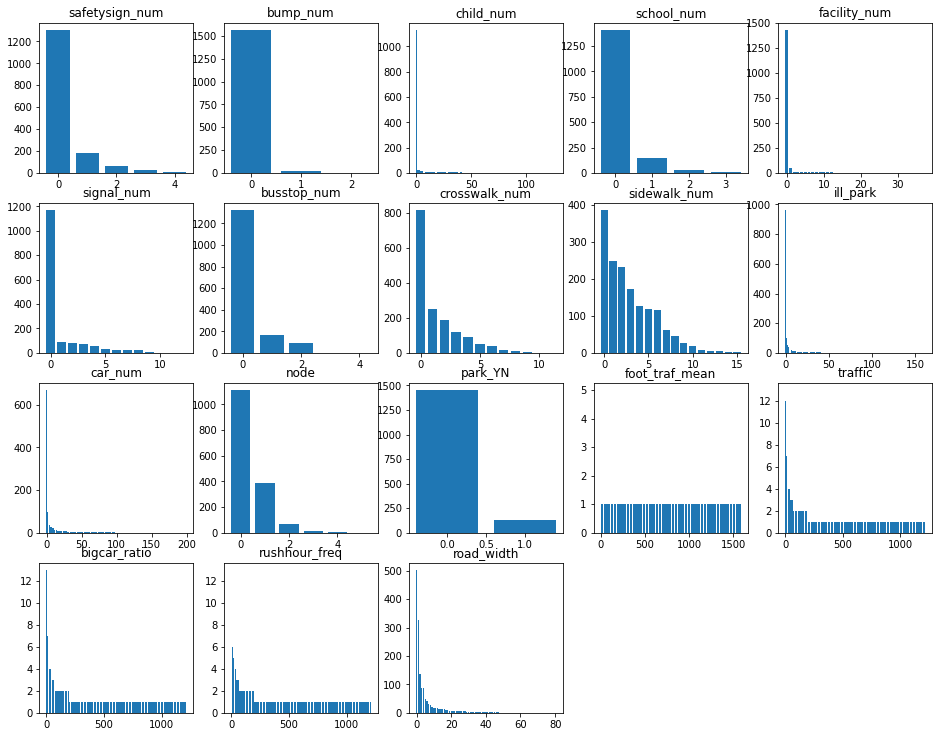

In [31]:
figg = plt.figure(figsize=(16,16))
for i in range(4,22):
    colname = dataset.columns[i]
    temp = pd.DataFrame(dataset[colname].value_counts()).reset_index()
    ax = figg.add_subplot(5,5, i-3)
    ax.bar(temp.index, temp[colname])
    ax.set_title(colname)
figg.show()

- outlier 없다

In [32]:
dataset

,gid,accident_cnt,geometry,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,...,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
3,다사564096,1,MULTIPOLYGON (((127.0087950432604 37.184159165...,0,1,0,0.0,0,0,0,...,0,0,0,1,0,42.714375,4779.710000,0.232100,4.6300,0.500
11,다사569091,0,MULTIPOLYGON (((127.0144567913441 37.179675470...,0,0,0,0.0,0,0,0,...,0,0,0,1,0,17.366065,2982.066667,0.338792,35.0050,0.500
12,다사569092,0,MULTIPOLYGON (((127.0144510220025 37.180576853...,0,1,0,0.0,0,0,0,...,0,0,1,0,1,27.409931,4835.990000,0.232096,5.2850,0.500
13,다사569093,0,MULTIPOLYGON (((127.014445252404 37.1814782360...,0,0,0,0.0,0,0,0,...,0,0,0,0,1,7.110000,4835.990000,0.232096,5.2850,0.500
14,다사570088,0,MULTIPOLYGON (((127.0156005712868 37.176975930...,0,0,0,0.0,0,0,0,...,0,0,3,0,0,11.820111,1607.680000,0.372530,99.7800,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,다사640065,0,MULTIPOLYGON (((127.0945650795965 37.156539968...,0,0,0,0.0,0,0,0,...,2,5,0,0,0,2.442500,1936.405000,0.117912,29.0625,0.625
1705,다사640066,0,MULTIPOLYGON (((127.0945602661362 37.157441364...,0,0,0,0.0,0,0,0,...,2,77,0,0,0,171.749722,2293.930000,0.057351,19.6000,0.500
1706,다사640067,0,MULTIPOLYGON (((127.0945554524616 37.158342760...,0,0,0,0.0,0,0,0,...,2,4,0,0,0,0.000000,2293.930000,0.057351,19.6000,0.500
1707,다사641063,0,MULTIPOLYGON (((127.0957008616508 37.154741021...,0,0,0,0.0,0,0,0,...,2,9,0,1,0,9.059167,1578.880000,0.178473,38.5250,0.750


- dataset 정제 완료